In [1]:
import os
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from numpy import newaxis, concatenate
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error
from pandas import read_csv, DataFrame,concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
seq_len = 1
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(),list()
    for i in range(n_in, 0 ,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis =1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace = True)
    return agg

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()
def predict_sequences_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, window_size-1,predicted[-1], axis=0)
    return predicted

In [3]:
dataset = read_csv('input2.csv', header = None, index_col=0)
dataset_stock = read_csv('stock.csv', header = None, index_col=None)
values = dataset.values
#print (values)
values_stock = dataset_stock.values
#print (values_stock)
encoder = LabelEncoder()
values[:,2] = encoder.fit_transform(values[:,2])
values_stock[:,0] = encoder.fit_transform(values_stock[:,0])
values = values.astype('float32')
values_stock = values_stock.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled_stock = scaler.fit_transform(values_stock)
reframed = series_to_supervised(scaled, 1, 1)
reframed_stock = series_to_supervised(scaled_stock, 1, 1)
print(reframed.head())
#print(reframed_stock.head())
#print (scaled_stock)

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)   var2(t)   var3(t)
1   0.240938   0.609842   0.157798  0.243070  0.590510  0.161468
2   0.243070   0.590510   0.161468  0.240938  0.657293  0.150459
3   0.240938   0.657293   0.150459  0.243070  0.578207  0.177982
4   0.243070   0.578207   0.177982  0.240938  0.636204  0.166972
5   0.240938   0.636204   0.166972  0.211087  0.576450  0.179817


In [4]:
values = reframed.values
values_stock = reframed_stock.values
n_train_hours = 76
n_end = n_train_hours + 5
train = values[:n_train_hours, :]
train_stock = values_stock[:n_train_hours,:]
test = values[n_train_hours:n_end :]
test_stock = values_stock[n_train_hours:n_end:]
train_X, train_y = train[:,:-1], train[:, -1]
train_stock_X, train_stock_y = train_stock[:,:-1], train_stock[:, -1]
test_X, test_y = test[:, :-1], test[:,-1]
test_stock_X, test_stock_y = test_stock[:, :-1], test_stock[:,-1] 
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
train_stock_X = train_stock_X.reshape((train_stock_X.shape[0], 1, train_stock_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
test_stock_X = test_stock_X.reshape((test_stock_X.shape[0],1, test_stock_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_stock_X.shape, train_stock_y.shape, test_stock_X.shape, test_stock_y.shape)

(76, 1, 5) (76,) (5, 1, 5) (5,)
(76, 1, 1) (76,) (5, 1, 1) (5,)


In [10]:
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
start = time.time()
model.add(Dense(1))
model.compile(loss="mse", optimizer="rmsprop")
print("> Compilation Time :", time.time() - start)
history = model.fit(train_X, train_y, epochs=30, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
#print (seq_len)
#predicted = predict_sequences_full(model, test_X, seq_len)

> Compilation Time : 0.021860122680664062
Train on 76 samples, validate on 5 samples
Epoch 1/30
0s - loss: 0.0027 - val_loss: 0.0032
Epoch 2/30
0s - loss: 8.9909e-04 - val_loss: 0.0036
Epoch 3/30
0s - loss: 0.0011 - val_loss: 0.0036
Epoch 4/30
0s - loss: 9.9985e-04 - val_loss: 0.0036
Epoch 5/30
0s - loss: 9.3280e-04 - val_loss: 0.0038
Epoch 6/30
0s - loss: 7.0884e-04 - val_loss: 0.0039
Epoch 7/30
0s - loss: 9.7722e-04 - val_loss: 0.0042
Epoch 8/30
0s - loss: 6.9366e-04 - val_loss: 0.0048
Epoch 9/30
0s - loss: 7.9822e-04 - val_loss: 0.0036
Epoch 10/30
0s - loss: 6.9768e-04 - val_loss: 0.0046
Epoch 11/30
0s - loss: 8.1735e-04 - val_loss: 0.0047
Epoch 12/30
0s - loss: 7.8349e-04 - val_loss: 0.0045
Epoch 13/30
0s - loss: 8.2318e-04 - val_loss: 0.0044
Epoch 14/30
0s - loss: 7.2125e-04 - val_loss: 0.0047
Epoch 15/30
0s - loss: 6.5647e-04 - val_loss: 0.0042
Epoch 16/30
0s - loss: 8.0858e-04 - val_loss: 0.0049
Epoch 17/30
0s - loss: 7.1690e-04 - val_loss: 0.0049
Epoch 18/30
0s - loss: 6.1766e-

KeyboardInterrupt: 

5


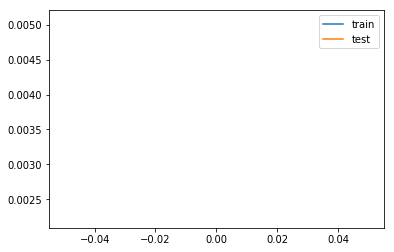

In [6]:
#print (predicted)
l = len(predicted)
print (l)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

[ 0.07565841  0.06248292  0.06196659  0.06194638  0.06194559] [ 0.16513762  0.14128441  0.10825688  0.04770642  0.05688073]
MSE: 0.003317


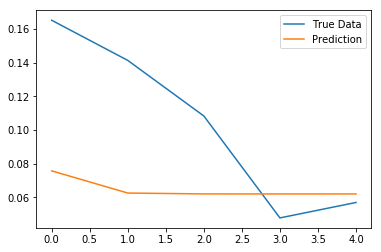

In [123]:
predicted = np.reshape(predicted, (l,))

print(predicted, test_stock_y)
score = mean_squared_error(predicted, test_stock_y)
    
print("MSE: %f" % score)
plot_results(predicted, test_stock_y)